In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

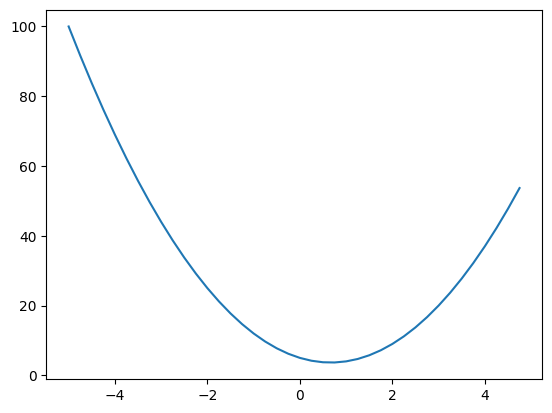

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [5]:
h = 0.00000001
x = 2/3
(f(x + h) - f(x)) / h

0.0

In [6]:
h = 0.0001

#inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print('d1:', d1)
print('d2:', d2)
print('slope:', (d2 - d1)/h)

d1: 4.0
d2: 4.0001
slope: 0.9999999999976694


#### Implementing `Value` Class

In [7]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op        
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward        
        return out

    def __radd__(self, other):
        return self + other

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        return out

    def __rmul__(self, other):
        return self * other

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supports int/float powers for now"
        out = Value(self.data**other, (self, ), f"**{other}")

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward
    
        return out

    def __truediv__(self, other):
        return self * other**-1

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
          self.grad += out.data * out.grad
        out._backward = _backward
        
        return out

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
          if v not in visited:
            visited.add(v)
            for child in v._prev:
              build_topo(child)
            topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
          node._backward()

In [8]:
beta = Value(2.0)
alpha = Value(6.0)
beta.exp()

Value(data=7.38905609893065)

In [9]:
a = Value(2.0, label = 'a')
b = Value(-3.0, label = 'b')
c = Value(10.0, label = 'c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'

f = Value(-2.0, label='f')
L = d * f; L.label='L'
L

Value(data=-8.0)

### Implementing Trace_graph

In [10]:
from graphviz import Digraph

def trace(root: Value):
    nodes, edges = set(), set()
    def build(v: Value):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges


def draw_dot(root, format='svg', rankdir="LR"):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir})

    for n in nodes:
        dot.node(
            name=str(id(n)),
            label="{ %s | data %.4f | grad %.4f }"% (n.label, n.data, n.grad),
            shape='record',
        )
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

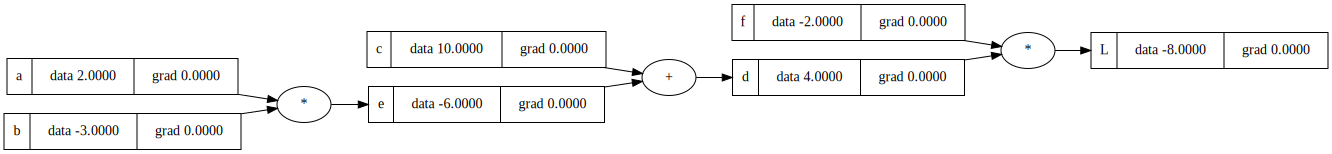

In [11]:
draw_dot(L)

#### List of derivatives from all nodes
L = d * f <br>
dL/dd = f = -2.0<br>
dL/df = d = 4.0<br>

d = c + e<br>
dd/dc = 1.0<br>
dd/de = 1.0<br>
dL/dc = (dL/dd) * (dd/dc) = dL/dd = f = -2.0<br>
dL/de = (dL/dd) * (dd/de) = dL/dd = f = -2.0<br>

e = a * b<br>
de/da = b = -3.0<br>
de/db = a = 2.0<br>
dL/da = (dL/de) * (de/da) = -2.0 * -3.0 = 6.0<br>
dL/da = (dL/de) * (de/db) = -2.0 * 2.0 = -4.0<br>

In [12]:
L.grad = 1.0
f.grad = 4.0
d.grad = -2.0
c.grad = -2.0
e.grad = -2.0
a.grad = 6.0
b.grad = -4.0

In [13]:
def lol():
    h = 0.0001

    a = Value(2.0, label = 'a')
    b = Value(-3.0, label = 'b')
    c = Value(10.0, label = 'c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    
    f = Value(-2.0, label='f')
    L = d * f; L.label='L'
    L1 = L.data

    a = Value(2.0, label = 'a')
    b = Value(-3.0, label = 'b')
    b.data += h
    c = Value(10.0, label = 'c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    
    f = Value(-2.0, label='f')
    L = d * f; L.label='L'
    L2 = L.data

    print((L2 - L1) / h)

lol()

-4.000000000008441


#### Single Optimization Step

In [14]:
lr = 0.01
a.data += lr * a.grad
b.data += lr * b.grad
c.data += lr * c.grad
f.data += lr * f.grad

e = a*b
d = e+c
L = d*f

print(L.data)

-7.286496


#### Display `tanh`

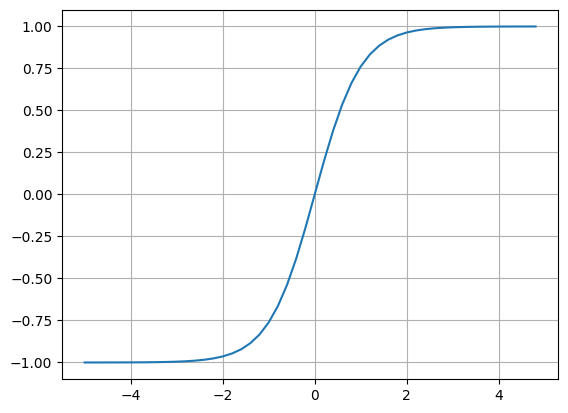

In [15]:
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2))); plt.grid();

#### Single Neuron in action

In [16]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias 
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1x2w2";
n = x1w1x2w2 + b; n.label = "n";

o = n.tanh(); o.label = "o";

o.backward()

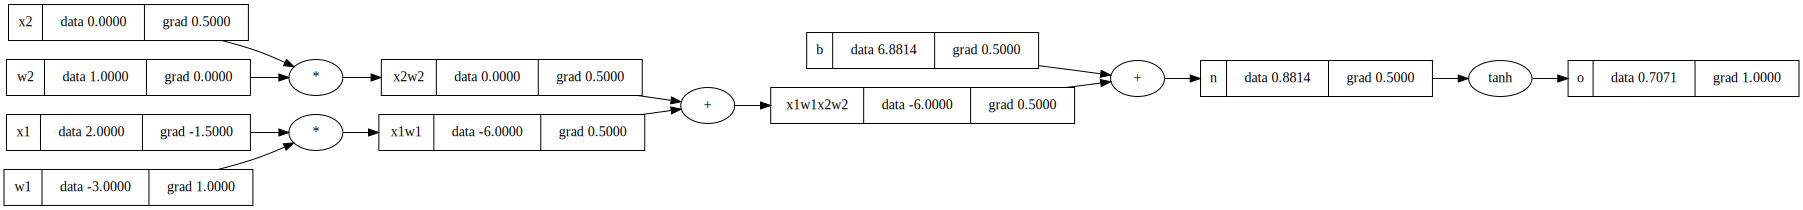

In [17]:
draw_dot(o)

#### Derivatives from all the nodes of a `Neuron`

o = tanh(n) = 0.7071\
do/dn = 1 - tanh(n)<sup>2</sup> = 1 - o<sup>2</sup> = 0.5

n = x1w1x2w2 + b\
do/dx1w1x2w2 = (dn/dx1w1x2w2) * (do/dn) = 1.0 * 0.5 = 0.5\
do/db = (dn/db) * (do/dn) = 1.0 * 0.5 = 0.5

x1w1x2w2 = x1w1 + x2w2\
do/dx1w1 = 1.0 * 0.5 = 0.5\
do/x2w2 = 1.0 * 0.5 = 0.5

x1w1 = x1 * w1\
do/dx1 = (do/dx1w1) * (dx1w1/dx1)\
do/dw1 = (do/dx1w1) * (dx1w1/dw1)\
do/dx2 = (do/dx2w2) * (dx2w2/dx2)\
do/dw2 = (do/dx2w2) * (dx1w1/dw2)

In [18]:
o.grad = 1.0
o._backward()

# n.grad = 0.5
n._backward()

# x1w1x2w2.grad = 0.5
# b.grad = 0.5
x1w1x2w2._backward()

# x1w1.grad = 0.5
# x2w2.grad = 0.5

x2w2._backward()
x1w1._backward()
# x1.grad = w1.data * x1w1.grad
# w1.grad = x1.data * x1w1.grad
# x2.grad = w2.data * x2w2.grad
# w2.grad = x2.data * x2w2.grad

#### Breaking down the `tanh`

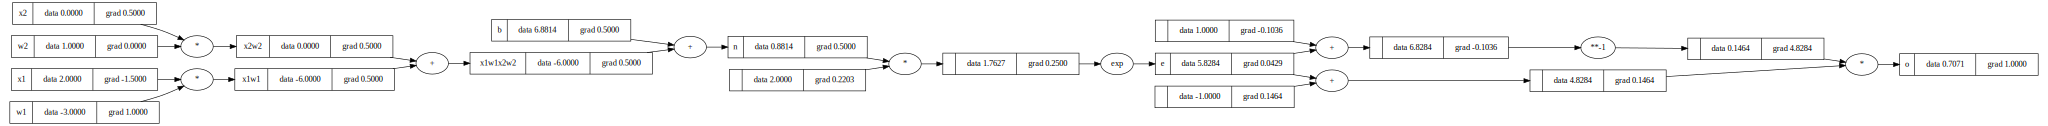

In [19]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias 
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1x2w2";
n = x1w1x2w2 + b; n.label = "n";

e = (2*n).exp(); e.label = "e"
o = (e - 1) / (e + 1); o.label = "o";

o.backward()
draw_dot(o)

#### Ensure multiuse of a Value

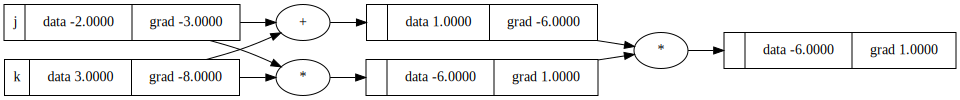

In [20]:
j = Value(-2.0, label='j')
k = Value(3.0, label='k')
l = j * k; d.label = 'l';
p = j + k; e.label = 'p';
q = l * p; f.label = 'q';

q.backward()

draw_dot(q)

In [21]:
import torch
import random

In [22]:
x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True

# weights
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True

# bias 
b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [30]:
class Neuron:

    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:

    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

x = [2.0, 3.0, -1.0]
n = MLP(len(x), [4, 4, 1])
n(x)

### Run a simple Training Step

Here is simple traning data with 4 data points

In [77]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0]

Calculate the initial loss

In [78]:
ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=0.0007956112833903178)

In [79]:
# Update the gradients based on loss
loss.backward()

Update the parameters

In [80]:
for p in n.parameters():
    p.data += -0.01 * p.grad

In [81]:
ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=0.0003128243411908364)

In [82]:
ypred

[Value(data=0.9921914473713288),
 Value(data=-0.9977646463103309),
 Value(data=-0.9968521889849893),
 Value(data=0.9846069714892758)]

### Training Loop

In [87]:
model = MLP(3, [4, 4, 1])
lr = 0.01

for k in range(20):

    # forward pass
    ypred = [model(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

    # backward pass
    # set the grad to zero first
    for p in model.parameters():
        p.grad = 0.0
    loss.backward()

    # update
    for p in model.parameters():
        p.data += -lr * p.grad

    print(k, loss.data)

0 5.779191275243996
1 5.190588147432258
2 4.517991049901842
3 3.835030474550057
4 3.2039911553891844
5 2.654104844193516
6 2.190444091597524
7 1.8098781885872133
8 1.5062830776007246
9 1.2696033635273885
10 1.0865884458760053
11 0.9437552827926683
12 0.8298735103565593
13 0.7367655840678681
14 0.6589214451095098
15 0.5927329598186734
16 0.5358041814523833
17 0.48646908991782406
18 0.4434965969277229
19 0.4059238410627969


In [88]:
ypred

[Value(data=0.8233628307549231),
 Value(data=-0.7123456885245668),
 Value(data=-0.809601980090072),
 Value(data=0.49430568264231406)]